
# Preprocessing for MIT data shift (Binary classification) with MinMax Scaler and Oversamling
The default preprocessing step is what we conclude in our report. 
You can check below what should be input for this notebook and what would be the output if necessary.


Processing **steps** for MIT dataset:   
    resample: Oversampling  
    rescaling: MinMaxScaler  


**Input** : Cleaned data with dummy target variable.   
mitbih_test.csv   
mitbih_train.csv

**Output** : Sampled and Scaled data with dummy target:   
mitbih_binary_train_shift_minmax_oversampling.csv  
mitbih_binary_test_shift_minmax_oversampling.csv  
mit_shift_scaler.pkl  (prepare for product env)


In [1]:
import sys
import os
data_path = ''
data_output_path = ''
# Check if the environment is Google Colab
if 'google.colab' in sys.modules:
    print("Running on Google Colab")
    # Install required libraries
    !pip install scikit-learn -q
    !pip install pandas -q
    !pip install numpy -q
    !pip install imbalanced-learn -q


    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    # set the path where the csv file stored in your google drive. 
    data_path = '/content/drive/MyDrive/Heartbeat_Project/'
    data_output_path = data_path
    
else:
    print("Running on local environment")

    current_path = os.getcwd()
    print("Current working directory:", current_path)
    data_path = '../data/raw/'
    data_output_path = '../data/processed/'


Running on local environment
Current working directory: /Users/pingyuan/Documents/codeself/heartbeat-analysis-ai/notebooks


In [2]:
# Verify installation and import libraries
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import joblib

RawFiles = dict({
    'test': data_path +  'mitbih_test.csv',
    'train': data_path +  'mitbih_train.csv', 
})

OutputFiles = dict({
    'test': data_output_path + 'mitbih_binary_test_shift_minmax_oversampling.csv',
    'train': data_output_path + 'mitbih_binary_train_shift_minmax_oversampling.csv',
})

In [3]:
def addColumnsToDataframe(df):
    """
    As the dataset is composed with 188 columns with the 188th columns as the category values,
    so we give the last column the name 'target', others named with 'c_182'
    """
    num_columns= df.shape[1]
    feature_col_name = ['c_' + str(i) for i in range(0, num_columns - 1)]
    df_columns = feature_col_name + ['target']
    df.columns = df_columns
    return df
def convertColumnAsInt(df, column):
    df[column] = pd.to_numeric(df[column], errors='coerce') # convert to numeric to handle NaN values
    df.dropna(subset=[column], inplace=True)  # drop the rows with NaN values
    df[column] = df[column].astype(int)  # convert to int
    return df

def plotDataAsLine(df, first, count=1):
    # data = df.head(first)
    data = df.iloc[first: first+count]
    for index, row in data.iterrows():
        plt.plot(data.columns, row)

    plt.grid(False)
    plt.show()

In [4]:
mitbih_train = pd.read_csv(RawFiles.get('train'), header=None ) 
mitbih_test = pd.read_csv(RawFiles.get('test'), header=None )

mitbih_train = addColumnsToDataframe(mitbih_train)
mitbih_train = convertColumnAsInt(mitbih_train, 'target')

mitbih_test = addColumnsToDataframe(mitbih_test)
mitbih_test = convertColumnAsInt(mitbih_test, 'target')

# target value and meanings
all_class_mapping = {
    0: 'Normal',
    1: 'Supraventricular',
    2: 'Ventricular',
    3: 'Fusion',
    4: 'Unclassifiable'
}
mitbih_train['target'] = mitbih_train['target'].map(all_class_mapping)
mitbih_test['target'] = mitbih_test['target'].map(all_class_mapping)

# Drop rows where 'target' is 'Unclassifiable beat'
mitbih_train = mitbih_train[mitbih_train['target'] != 'Unclassifiable']
mitbih_test = mitbih_test[mitbih_test['target'] != 'Unclassifiable']

# convert to binary classification Combine abnormal categories
mitbih_train['target'] = mitbih_train['target'].replace(['Supraventricular', 'Ventricular', 'Fusion'], 'abnormal')
mitbih_test['target'] = mitbih_test['target'].replace(['Supraventricular', 'Ventricular', 'Fusion'], 'abnormal')

# Encode the labels: normal as 0, abnormal as 1
mitbih_train['target'] = mitbih_train['target'].replace({'Normal': 0, 'abnormal': 1})
mitbih_test['target'] = mitbih_test['target'].replace({'Normal': 0, 'abnormal': 1})

#drop null value  
mitbih_train = mitbih_train.dropna(how='any')
mitbih_test = mitbih_test.dropna(how='any')




/var/folders/7l/y9wp4lwn1zs33k6r9j_jn10c0000gn/T/ipykernel_2687/3159785236.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mitbih_train['target'] = mitbih_train['target'].replace({'Normal': 0, 'abnormal': 1})
/var/folders/7l/y9wp4lwn1zs33k6r9j_jn10c0000gn/T/ipykernel_2687/3159785236.py:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mitbih_test['target'] = mitbih_test['target'].replace({'Normal': 0, 'abnormal': 1})


In [5]:
mitbih_train["target"].value_counts()

target
0    72471
1     8652
Name: count, dtype: int64

In [6]:
mitbih_test["target"].value_counts()

target
0    18118
1     2166
Name: count, dtype: int64

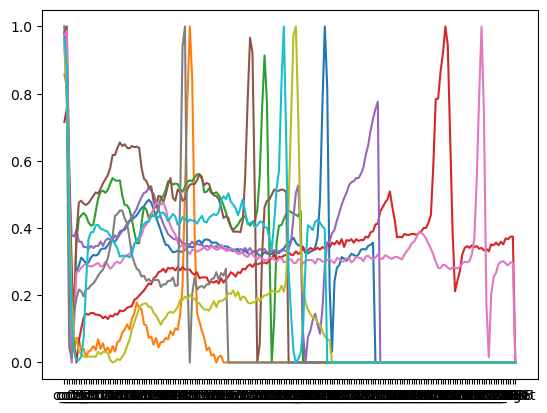

In [22]:
plotDataAsLine(mitbih_test, 10000, 10)

# Shift data
1. for each rows find the peak (take the peak which is around center of signal)
2. get average of peak => the center of peak 
3. shift each rows's peak to the center of peak. 

In [7]:
import pandas as pd
from scipy.signal import find_peaks
import os
import numpy as np

# Function to find the Top-N highest and lowest peaks in a single signal
def find_top_n_peaks(signal, n=5):
    # Find highest peaks
    high_peaks, _ = find_peaks(signal)
    high_peaks_values = signal[high_peaks]
    top_high_peaks = sorted(zip(high_peaks, high_peaks_values), key=lambda x: -x[1])[:n]

    # Find lowest peaks 
    low_peaks, _ = find_peaks(signal * -1) # -1 means invert the signal to find the lowest peaks
    low_peaks_values = signal[low_peaks]
    top_low_peaks = sorted(zip(low_peaks, low_peaks_values), key=lambda x: x[1])[:n]

    return top_high_peaks, top_low_peaks

def find_peak_one_row(data) -> int:
    ### find the peak which take the whole ecg signal 
    ### return the index 
    high_peaks, _ = find_peaks(data)
    # as we need about 75 - 125 signal to identify the whole ecg period
    # in this case the maximum R wave may appear at first 6-10 , or 8-15
    # based on that we can conclude the valid peak may exists in range of [6, 160 ]
    # valid_high_peaks = [ value for value in high_peaks if 6<=value<=160]
    valid_high_peaks = [ value for value in high_peaks if 15<=value<=150]
    high_peaks_values = data[high_peaks]
    high_peaks_values = data[ valid_high_peaks if len(valid_high_peaks)> 0 else high_peaks   ]
    top_high_peaks = sorted(zip(high_peaks, high_peaks_values), key=lambda x: -x[1])[:1]

    return top_high_peaks[0][0]

def shift_row(data, center): 
    peak = find_peak_one_row(data)
    target = data[-1]

    # Calculate the shift needed to move the highest value to the center
    shift = center - peak
    
    # Create an output array filled with None
    shifted_array = [0] * len(data)
    
    # Shift the elements and handle out-of-bound cases
    for i in range(len(data)):
        new_index = i + shift
        if 0 <= new_index < len(data):  # Ensure new index is within bounds
            shifted_array[new_index] = data[i]
    shifted_array[-1] = target
    return pd.Series(shifted_array)

def get_shift_dataframe(df, center):
    
    df_shifted = df.apply( lambda row:  shift_row(row, center), axis=1)

    return df_shifted


df_train = get_shift_dataframe(mitbih_train, 87)
df_train.head()
df_test = get_shift_dataframe(mitbih_test, 87)


# df_train = mitbih_train
# df_test = mitbih_test

# print(find_peak_one_row(mitbih_train.iloc[0]))

# globalPeakAverage = np.array([find_peak_one_row(x) for x in mitbih_train.values]) #mitbih_train.values[ for x in ].map(lambda data: find_peak_one_row(data))

# print(np.average(globalPeakAverage))

#print('average is': np.array)

# 87 as center 

# 75 - 125 to cover a whole heartbeat 


/var/folders/7l/y9wp4lwn1zs33k6r9j_jn10c0000gn/T/ipykernel_2687/3999930809.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  high_peaks_values = data[high_peaks]
/var/folders/7l/y9wp4lwn1zs33k6r9j_jn10c0000gn/T/ipykernel_2687/3999930809.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  high_peaks_values = data[ valid_high_peaks if len(valid_high_peaks)> 0 else high_peaks   ]
/var/folders/7l/y9wp4lwn1zs33k6r9j_jn10c0000gn/T/ipykernel_2687/3999930809.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent wit

<class 'pandas.core.frame.DataFrame'>
RangeIndex(start=0, stop=188, step=1)


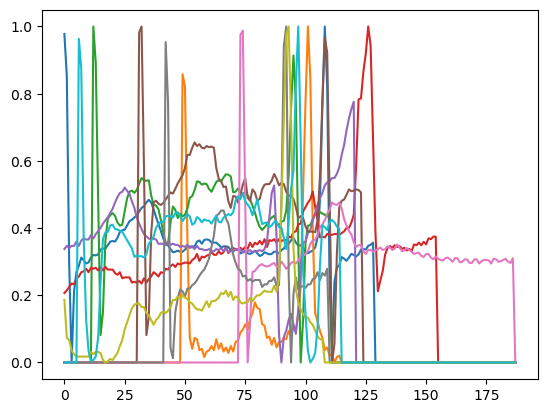

In [8]:
print(type(df_test))
print(df_test.columns)
plotDataAsLine(df_test, 10000, 10)

In [9]:
df_train_column = addColumnsToDataframe(df_train)
df_test_column = addColumnsToDataframe(df_test)

# df_coloumn.head()

In [10]:
# split train test set before resampling

shifted_mit_train = df_train_column
shifted_mit_test = df_test_column

shifted_mit_train = shifted_mit_train.fillna(0)
shifted_mit_test = shifted_mit_test.fillna(0)

X_train = shifted_mit_train.drop(columns=['target'], inplace=False) # drop the target column
X_test = shifted_mit_test.drop(columns=['target'], inplace=False) # drop the target column

y_train = shifted_mit_train['target'] # only the target column
y_test = shifted_mit_test['target'] # only the target column


# Resampling the train data with Oversampling before scaling with MinMaxScaler
ros = RandomOverSampler(random_state=0)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Scaling with MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

scaler_to_export = MinMaxScaler()
scaler_to_export.fit(X_train_resampled.values)


MinMaxScaler()

Save shift scaler

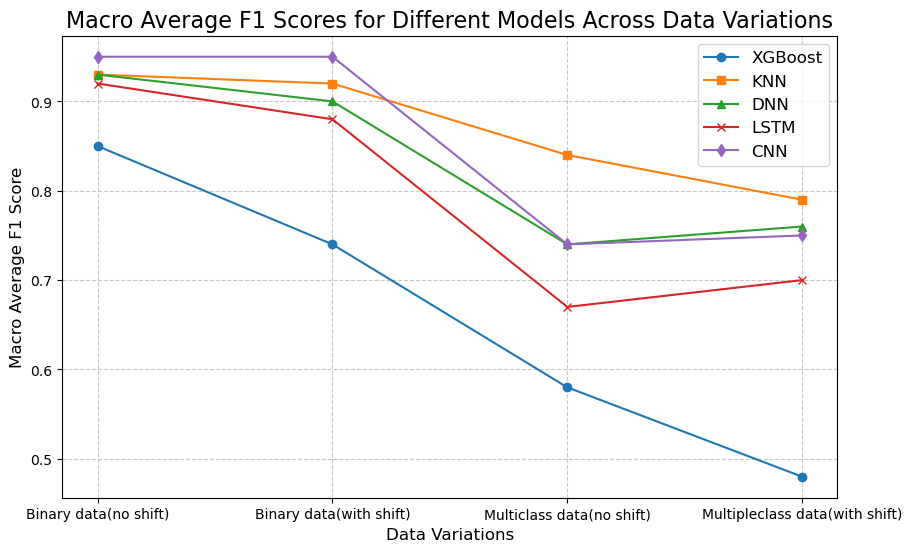

In [11]:
import matplotlib.pyplot as plt

# Sample data
x = ['Binary data(no shift)', "Binary data(with shift)", "Multiclass data(no shift)", "Multipleclass data(with shift)"]
y1 = [0.85, 0.74, 0.58, 0.48]
y2 = [0.93, 0.92, 0.84, 0.79]
y3 = [0.93, 0.90, 0.74, 0.76]
y4 = [0.92, 0.88, 0.67, 0.70]
y5 = [0.95, 0.95, 0.74, 0.75]

# Create the plot
plt.figure(figsize=(10, 6))  # Set the figure size

# Plot multiple lines
plt.plot(x, y1, label='XGBoost', marker='o')
plt.plot(x, y2, label='KNN', marker='s')
plt.plot(x, y3, label='DNN', marker='^')
plt.plot(x, y4, label='LSTM', marker='x')
plt.plot(x, y5, label='CNN', marker='d')

# Add title and labels
plt.title('Macro Average F1 Scores for Different Models Across Data Variations', fontsize=16)
plt.xlabel('Data Variations', fontsize=12)
plt.ylabel('Macro Average F1 Score', fontsize=12)

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

# Add legend
plt.legend(loc='upper right', fontsize=12)

# Show the plot
plt.show()

In [12]:

joblib.dump(scaler_to_export, data_output_path + "mit_binary_minmax_scaler.joblib")

['../data/processed/mit_binary_minmax_scaler.joblib']

In [13]:
# convert resampling rescaling data back to dataframe to concat
X_train_scaled_df =  pd.DataFrame(X_train_scaled, columns=[f'c_{i}' for i in range(X_train_scaled.shape[1])])
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=[f'c_{i}' for i in range(X_test_scaled.shape[1])])
y_train_resampled_df = pd.DataFrame(y_train_resampled, columns=['target'])
y_test_df = pd.DataFrame(y_test, columns=['target']) 


# concat X_train, y_train/ X_test, y_test
shift_mitbih_train_clean_default = pd.concat(
    [
        X_train_scaled_df,
        y_train_resampled_df
    ], axis=1)

shift_mitbih_test_clean_default = pd.concat(
    [  
        X_test_scaled_df,
        y_test_df.reset_index(drop=True)
    ], axis=1)


In [14]:
# save data to csv
shift_mitbih_train_clean_default.to_csv(OutputFiles.get('train'), index=False)
shift_mitbih_test_clean_default.to_csv(OutputFiles.get('test'), index=False)

In [27]:
from datetime import datetime
# Display the running time
print("Current time:", datetime.now())

Current time: 2024-12-27 12:07:50.862291
